<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='EU Copernicus Eumetsat logo' align='right' width='60%'></img>

<br>

# 1.2 MODIS Level 1B - Calibrated Radiances - True Color RGB - 1km

### About

This module shows the structure of `MODIS MOD021K Level 1B Calibrated Radiances` data and what information of the data files can be used in order to load, browse and visualize the data.

According to [NASA](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/MOD021KM#overview), "The MODIS Level 1B data set contains calibrated and geolocated at-aperture radiances for 36 discrete bands located in the 0.4 µm to 14.4 µm region of the electromagentic spectrum. These data are generated from MODIS Level-1A scans of raw radiance, and in the process are converted to geophysical units of W/(m2 µm sr)."






### Basic Facts

> **Spatial resolution**: `1 km at nadir`<br>
> **Spatial coverage**: `Global` <br>
> **Revisit time**: `Daily` <br>
> **Data availability**: `since 2002`


### How to access the data

This notebook uses the MODIS MOD21K dataset from the Terra platform. This data can be ordered via the [LAADS DAAC](https://ladsweb.modaps.eosdis.nasa.gov/search/order/2/MOD04_L2--61) and are distributed in `HDF4-EOS` format, which is based on `HDF4`. 

You need to [register for an Earthdata account](https://urs.earthdata.nasa.gov/) in order to be able to download data. 


### Module outline
- [1 - Load and browse MODIS MOD021 Level 1B data files](#modis_load)
- [2 - Browse and visualize RGB composite IDs](#rgb_composites)
- [3 - Generate a geographical subset around Sardinia, Italy](#geographical_subset)
- [4 - Visualize MODIS 'natural_color' RGB composite with Cartopy features](#vis_natural)
- [5 - Visualize MODIS 'dust' RGB composite with Cartopy features](#vis_dust)

<hr>

#### Load required libraries

In [ ]:
import sys
!{sys.executable} -m pip install cartopy netCDF4 h5netcdf==1.3.0 satpy==0.51.0 pyhdf h5py python-geotiepoints

In [2]:
import glob
import numpy as np

import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.axes import Axes

import satpy
from satpy.scene import Scene
from satpy import find_files_and_readers
import pyresample as prs

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [3]:
if os.path.exists("functions.ipynb"):
    %run functions.ipynb
elif os.path.exists("../functions.ipynb"):
    %run ../functions.ipynb
else:
    print("Helper functions notebook not found in any specified path. Downloading from Gitlab.")    
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/functions.ipynb
    %run functions.ipynb

In [4]:
if os.path.exists("bucket_functions.ipynb"):
    %run bucket_functions.ipynb
elif os.path.exists("../bucket_functions.ipynb"):
    %run ../bucket_functions.ipynb
else:
    print("Helper functions notebook not found in any specified path. Downloading from Gitlab.")    
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/90_workshops/202410_wmo_school/bucket_functions.ipynb
    %run bucket_functions.ipynb

In [5]:
base_url = 'https://s3.waw3-2.cloudferro.com/swift/v1/wmo/'
all_paths_list = list_data_on_bucket(base_url)

all_directories_list = [os.path.dirname(path) for path in all_paths_list if path.count('/') <= 4]
# Take unique directories
all_directories_list = list(np.unique(all_directories_list))
all_directories_list

Status ok



['eodata',
 'eodata/fci',
 'eodata/gome2',
 'eodata/gome2/aai',
 'eodata/gome2/hcho',
 'eodata/gome2/hcho/daily',
 'eodata/gome2/no2',
 'eodata/gome2/no2/daily',
 'eodata/iasi',
 'eodata/iasi/co',
 'eodata/iasi/nh3',
 'eodata/meteosat',
 'eodata/meteosat/2020',
 'eodata/meteosat/2024',
 'eodata/modis',
 'eodata/modis/10km',
 'eodata/modis/level_1b',
 'eodata/monarch',
 'eodata/pmap',
 'eodata/s3',
 'eodata/s3/aod',
 'eodata/s3/aod/S3A_SL_2_AOD____20240821T082340_20240821T082839_20240821T101507_0299_116_078______MAR_O_NR_003.SEN3',
 'eodata/s3/aod/S3A_SL_2_AOD____20240825T081954_20240825T082453_20240825T101112_0299_116_135______MAR_O_NR_003.SEN3',
 'eodata/s3/aod/S3A_SL_2_AOD____20240827T090833_20240827T091332_20240827T105910_0299_116_164______MAR_O_NR_003.SEN3',
 'eodata/s3/aod/S3B_SL_2_AOD____20240822T071826_20240822T072325_20240822T091012_0299_096_334______MAR_O_NR_003.SEN3',
 'eodata/s3/aod/S3B_SL_2_AOD____20240823T083336_20240823T083833_20240823T102404_0299_096_349______MAR_O_NR_00

#### Set geographical extent

In [6]:
latmin = 0
latmax = 40
lonmin = -50
lonmax = 20

<hr>

## <a id='modis_load'></a>1. Load and browse MODIS Level 1B Calibrated Radiances data

From the [LAADS DAAC](https://ladsweb.modaps.eosdis.nasa.gov/search/order/2/MOD021KM--61), we downloaded one tile of Level-1B Image data on 19 June 2020. 

Unfortunately,`satpy` cannot directly open files from an object storage service without first downloading the files locally. `satpy` expects local file paths to work with, as it reads files from disk.

In [8]:
data_paths = [path for path in all_paths_list if 'MOD021KM.A2020171.1110' in path]
data_paths

['eodata/modis/level_1b/MOD021KM.A2020171.1110.061.2020171192148.hdf']

In [9]:
download_directory = "../../downloads/"
file_names = download_data_from_bucket(base_url, data_paths, download_directory)

Downloaded file: ./MOD021KM.A2020171.1110.061.2020171192148.hdf


In [10]:
file_names

['./MOD021KM.A2020171.1110.061.2020171192148.hdf']

<br>

In a next step, we use the `Scene` constructor from the [satpy](https://satpy.readthedocs.io/en/stable/index.html) library. Once loaded, a `Scene` object represents a single geographic region of data, typically at a single continuous time range.

You have to specify the two keyword arguments `reader` and `filenames` in order to successfully load a scene. As mentioned above, for MODIS Level-1B data, you can use the `modis_l1b` reader.

In [11]:
scn =Scene(filenames=file_names,reader='modis_l1b')
scn

<br>

A `Scene` object is a collection of different bands, with the function `available_dataset_names()`, you can see the available bands of the scene. To learn more about the bands of MODIS, visit [this website](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/modis/).

In [12]:
scn.available_dataset_names()

['1',
 '10',
 '11',
 '12',
 '13hi',
 '13lo',
 '14hi',
 '14lo',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'latitude',
 'longitude',
 'satellite_azimuth_angle',
 'satellite_zenith_angle',
 'solar_azimuth_angle',
 'solar_zenith_angle']

<br>

The underlying container for data in satpy is the `xarray.DataArray`. With the function `load()`, you can specify an individual band by name, e.g. `1` and *load* the data. If you then select the loaded band, you see that the band object is a `xarray.DataArray`. Band 1 has a bandwidth or wavelength of 620 - 670nm.

In [13]:
scn.load(['1'])
scn['1']

<xarray.DataArray 'getitem-17cd15f3f26e033df0144d6540b08604' (y: 2030, x: 1354)> Size: 11MB
dask.array<mul, shape=(2030, 1354), dtype=float32, chunksize=(1540, 1354), chunktype=numpy.ndarray>
Coordinates:
    crs      object 8B +proj=longlat +ellps=WGS84 +type=crs
Dimensions without coordinates: y, x
Attributes: (12/18)
    name:                 1
    resolution:           1000
    calibration:          reflectance
    coordinates:          ('longitude', 'latitude')
    wavelength:           0.645 µm (0.62-0.67 µm)
    file_type:            hdf_eos_data_1000m
    ...                   ...
    start_time:           2020-06-19 11:10:00
    end_time:             2020-06-19 11:15:00
    reader:               modis_l1b
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'getit...
    _satpy_id:            DataID(name='1', wavelength=WavelengthRange(min=0.6...
    ancillary_variables:  []

<br>

With an xarray data structure, you can handle the object as a `xarray.DataArray`. For example, you can print a list of available attributes with the function `attrs.keys()`. 

In [14]:
scn['1'].attrs.keys()

dict_keys(['name', 'resolution', 'calibration', 'coordinates', 'wavelength', 'file_type', 'modifiers', 'units', 'standard_name', 'platform_name', 'sensor', 'rows_per_scan', 'start_time', 'end_time', 'reader', 'area', '_satpy_id', 'ancillary_variables'])

<br>

With the `attrs()` function, you can also access individual metadata information, e.g. `start_time` and `end_time`.

In [15]:
scn['1'].start_time, scn['1'].end_time

(datetime.datetime(2020, 6, 19, 11, 10),
 datetime.datetime(2020, 6, 19, 11, 15))

<br>

## <a id='rgb_composites'></a> 2. Browse and visualize RGB composite IDs

RGB composites combine different channels of satellite data in order to get e.g. a true-color image of the scene. Depending on which channel combination is used, different features can be highlighted in the composite, e.g. dust. SatPy offers several predefined RGB composite options. The function `available_composite_ids()` returns a list of available composite IDs.

In [16]:
scn.available_composite_ids()

Too many possible datasets to load for DataQuery(wavelength=0.67)


[DataID(name='24h_microphysics'),
 DataID(name='airmass'),
 DataID(name='ash'),
 DataID(name='day_essl_colorized_low_level_moisture'),
 DataID(name='day_essl_low_level_moisture'),
 DataID(name='day_microphysics'),
 DataID(name='dust'),
 DataID(name='essl_colorized_low_level_moisture'),
 DataID(name='essl_low_level_moisture'),
 DataID(name='fog'),
 DataID(name='green_snow'),
 DataID(name='ir108_3d'),
 DataID(name='ir_cloud_day'),
 DataID(name='natural_color'),
 DataID(name='natural_color_raw'),
 DataID(name='natural_with_night_fog'),
 DataID(name='night_fog'),
 DataID(name='ocean_color'),
 DataID(name='overview'),
 DataID(name='snow'),
 DataID(name='true_color'),
 DataID(name='true_color_crefl'),
 DataID(name='true_color_thin'),
 DataID(name='true_color_uncorrected')]

<br>

Let us define a list with the composite ID `natural_color`. This list (`composite_id`) can then be passed to the function `load()`. Per default, scenes are loaded with the north pole facing downwards. You can specify the keyword argument `upper_right_corner=NE` in order to turn the image around and have the north pole facing upwards.

In [17]:
composite_ids = ['natural_color','dust']
scn.load(composite_ids, resolution=1000, upper_right_corner="NE")

<br>

A print of the Scene object `scn` shows you that three bands / composites are available: `natural_color`, `dust` and band `1`.

In [18]:
print(scn)

<xarray.DataArray 'getitem-17cd15f3f26e033df0144d6540b08604' (y: 2030, x: 1354)> Size: 11MB
dask.array<mul, shape=(2030, 1354), dtype=float32, chunksize=(1540, 1354), chunktype=numpy.ndarray>
Coordinates:
    crs      object 8B +proj=longlat +ellps=WGS84 +type=crs
Dimensions without coordinates: y, x
Attributes: (12/18)
    name:                 1
    resolution:           1000
    calibration:          reflectance
    coordinates:          ('longitude', 'latitude')
    wavelength:           0.645 µm (0.62-0.67 µm)
    file_type:            hdf_eos_data_1000m
    ...                   ...
    start_time:           2020-06-19 11:10:00
    end_time:             2020-06-19 11:15:00
    reader:               modis_l1b
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'getit...
    _satpy_id:            DataID(name='1', wavelength=WavelengthRange(min=0.6...
    ancillary_variables:  []
<xarray.DataArray 'where-9225671fbe057c47b6969a604f2a1881' (bands: 3, y: 2030,
      

<br>

## <a id='geographical_subset'></a>3. Generate a geographical subset around North-West Africa

Often, you might want to highlight a specific geographical region. Let us generate a geographical subset around Western Africa, where a dust cloud is visible. You can do this with the function stored in the `coord2area_def.py` script, which converts human coordinates (longitude and latitude) to an area definition. 

We need to define the following arguments: 
- `name` :the name of the area definition, set this to `africa_area_1km`
- `proj` : the projection, set this to `laea` which stands for the Lambert azimuthal equal-area projection
- `min_lat`: the minimum latitude value, set this to `0`
- `max_lat`: the maximum latitude value, set this to `40`
- `min_lon`: the minimum longitude value, set this to `-50`
- `max_lon`: the maximum longitude value, set this to `20`
- `resolution(km)`: the resolution in kilometres, set this to `1`

Afterwards, you can visualize the resampled image with the function `show()`.

In [ ]:
if not os.path.exists("coord2area_def.py"):
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/90_workshops/202410_wmo_school/01_dust/coord2area_def.py

In [19]:
%run coord2area_def.py africa_area_1km laea 0 40 -50 20 1

### +proj=laea +lat_0=20.0 +lon_0=-15.0 +ellps=WGS84

africa_area_1km:
  description: africa_area_1km
  projection:
    proj: laea
    ellps: WGS84
    lat_0: 20.0
    lon_0: -15.0
  shape:
    height: 4488
    width: 7776
  area_extent:
    lower_left_xy: [-3888106.710212, -1887930.177136]
    upper_right_xy: [3888106.710212, 2600168.053033]


From the values generated by `coord2area_def.py`, we copy and paste several into the template below. 

We need to define the following arguments in the code block template below: 
- `area_id` (string): the name of the area definition, set this to `africa_area_1km`
- `x_size` (integer): the number of values for the width, set this to the value of the shape `width`
- `y_size` (integer): the number of values for the height, set this to the value of the shape `height`
- `area_extent` (set of coordinates in brackets): the extent of the map is defined by 2 sets of coordinates, within a set of brackets `()` paste in the values of the `lower_left_xy` from the area_extent above, followed by the `upper_right_xy` values. 
- `projection` (string): the projection, paste in the first line after `###` starting with `+proj` 
- `description` (string): Give this a generic name for the region, 
- `proj_id` (string): A recommended format is the projection short code followed by lat_0 and lon_0

You should end up with the following code block.

In [20]:
from pyresample import get_area_def

area_id = 'africa_area_1km'

x_size = 2217
y_size = 2414
area_extent = (-3888106.710212, -1887930.177136, 3888106.710212, 2600168.053033)
projection = '+proj=laea +lat_0=20.0 +lon_0=-7.5 +ellps=WGS84'
description = "Africa"
proj_id = 'laea_20.0_7.5'

areadef = get_area_def(area_id, description, proj_id, projection,x_size, y_size, area_extent)

<br>

Next, you can use the area definition above in order to resample the loaded Scene object. You can use the function `resample()` to do so.

In [21]:
scn_resample_nc = scn.resample(areadef)
scn_resample_nc

<br>

Afterwards, you can visualize the resampled `natural_color` RGB with the function `show()`. You see see dust intrusions over the Mediterranean sea.

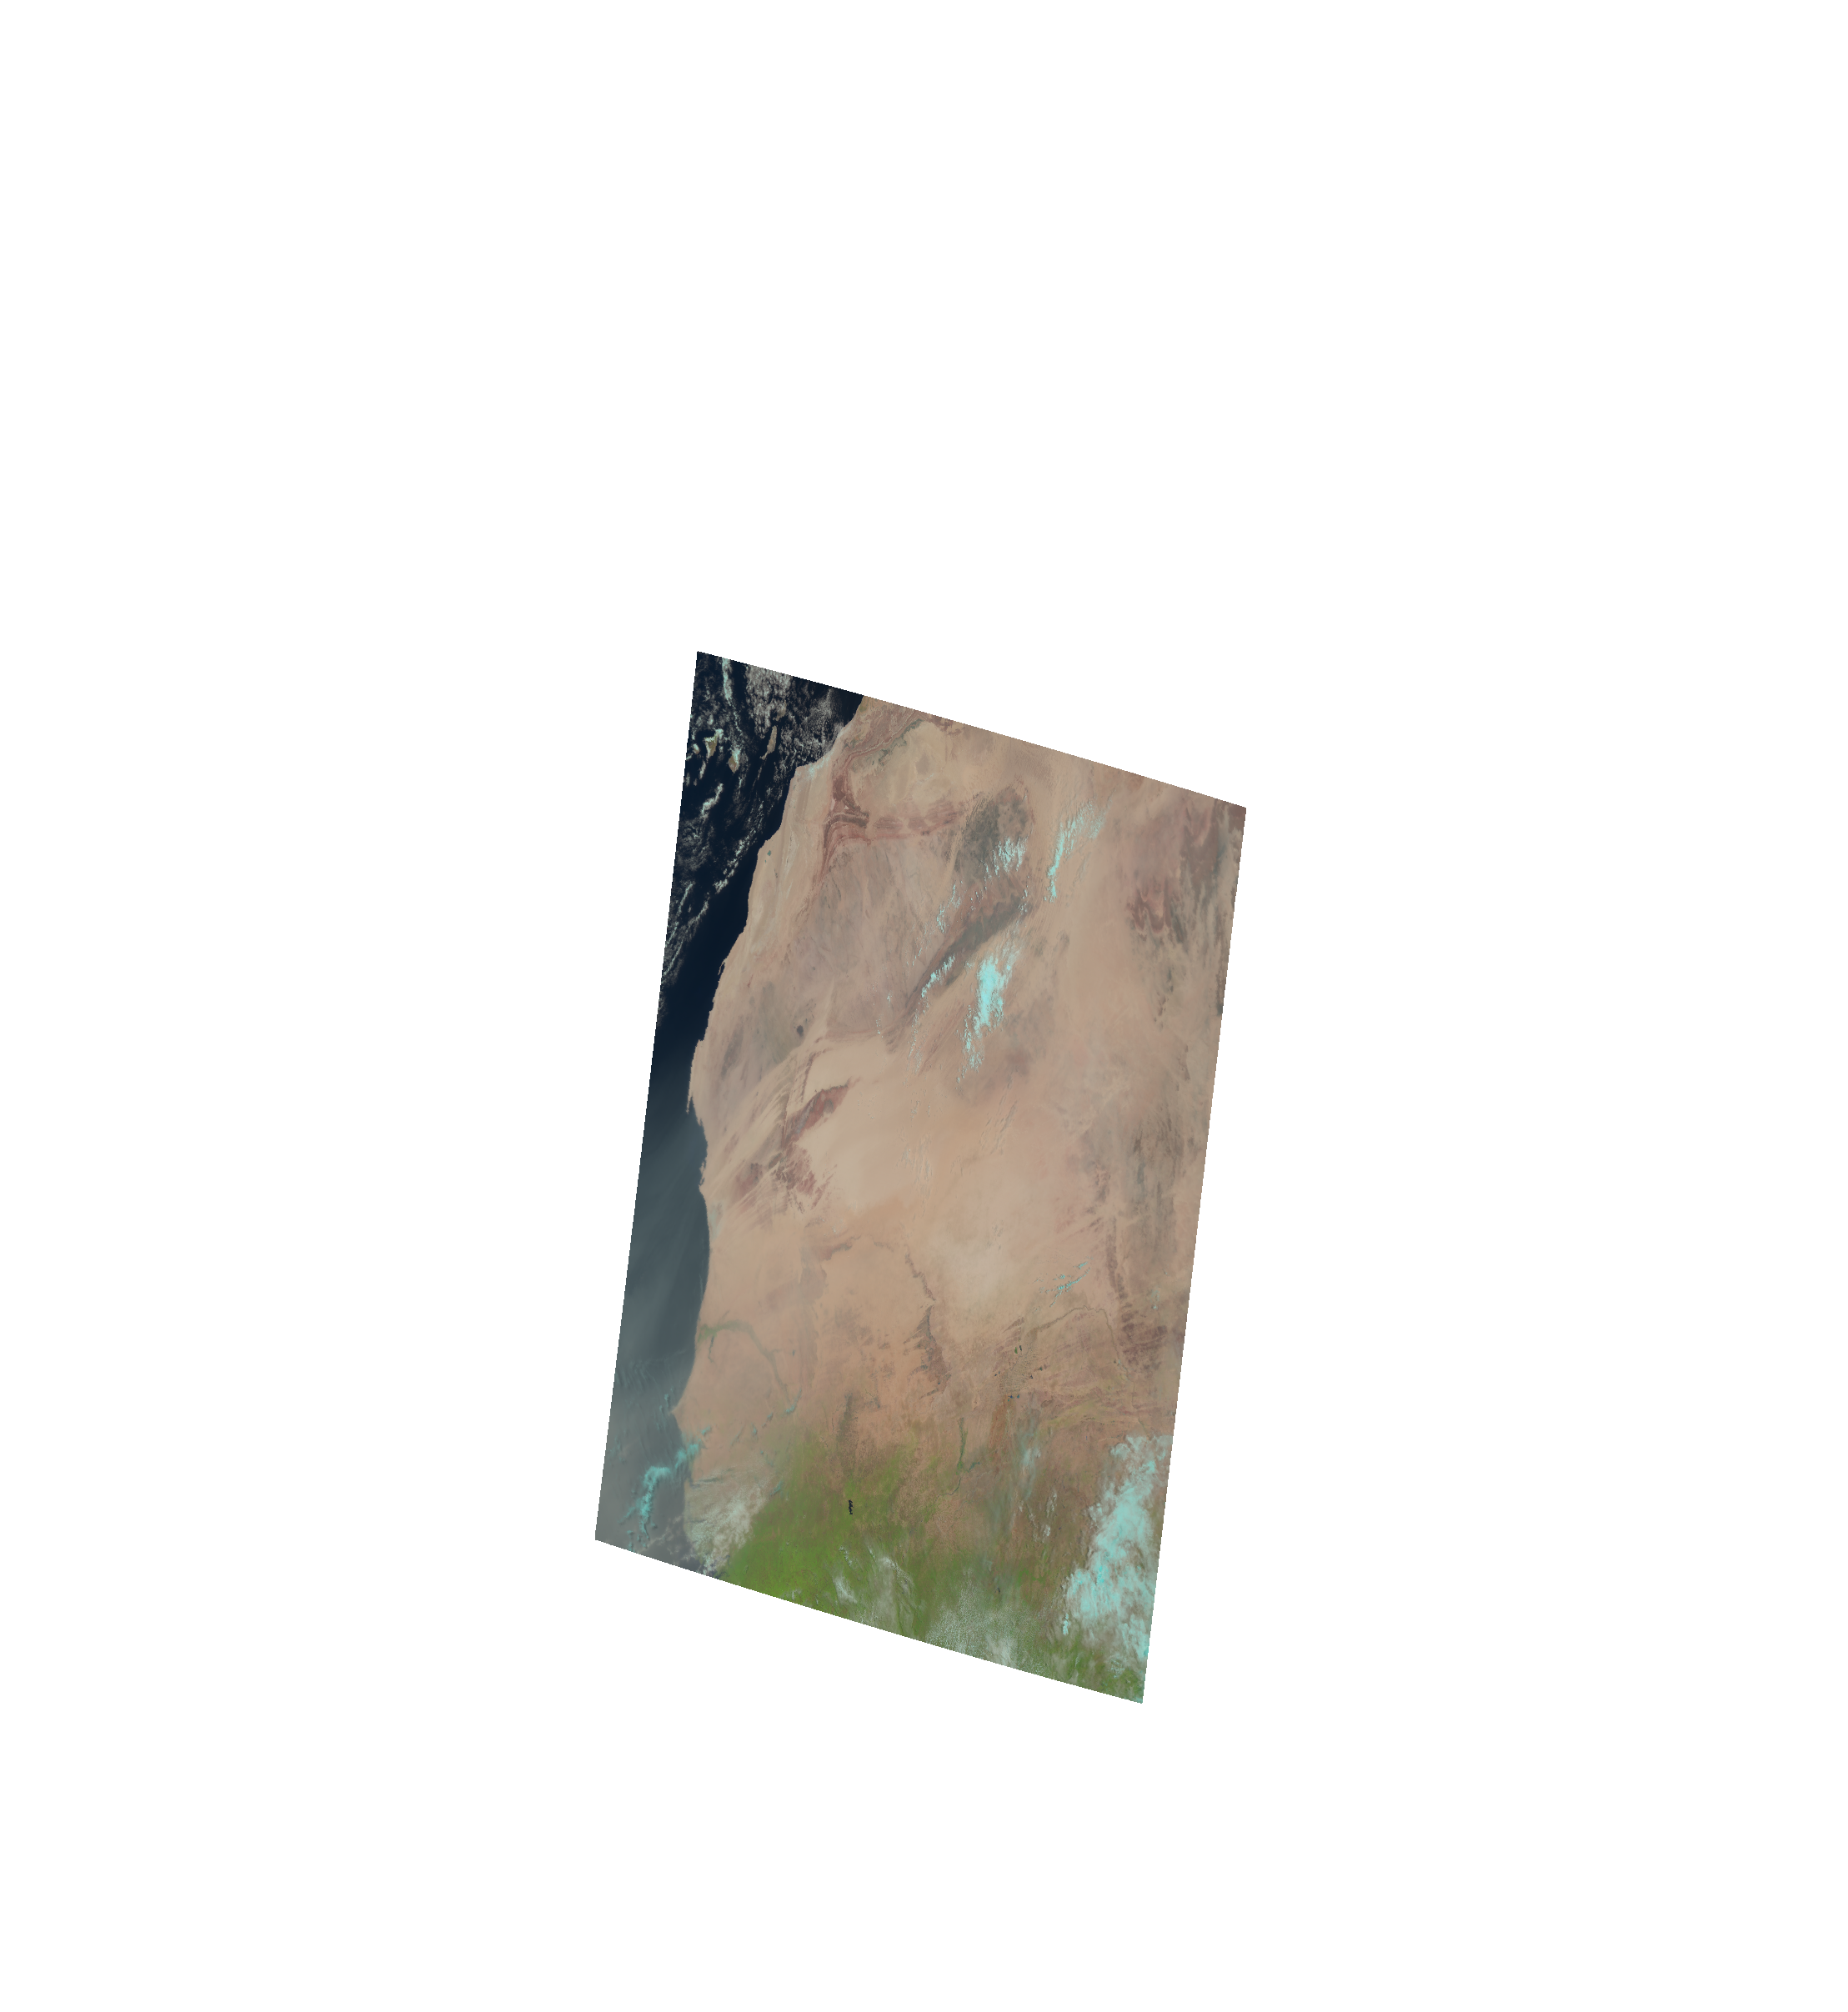

In [22]:
scn_resample_nc.show('natural_color')

<br>

## <a id='vis_natural'></a> 4. Visualize MODIS *natural_color* RGB composite with Cartopy features

SatPy's built-in visualization function is nice, but often you want to make use of additonal features, such as country borders. The library [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) offers powerful functions that enable the visualization of geospatial data in different projections and to add additional features to a plot. Below, we will show you how you can visualize the `natural_color` composite with the two Python packages [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/).

As a first step, we have to convert the `Scene` object into a numpy array. The numpy array additionally needs to be transposed to a shape that can be interpreted by matplotlib's function `imshow()`: (M,N,3). You can convert a Scene object into a `numpy.array` object with the function `np.asarray()`.

The shape of the array is `(3, 2414, 2217)`. This means we have to transpose the array and add index=0 on index position 3.

In [23]:
image = np.asarray(scn_resample_nc["natural_color"]).transpose(1,2,0)
image.shape

(2414, 2217, 3)

<br>

The next step is then to replace all nan values with 0. You can do this with the numpy function `nan_to_num()`. In a subsequent step, we then scale the values to the range between 0 and 1, clipping the lower and upper percentiles so that a potential contrast decrease caused by outliers is eliminated.


In [24]:
image = np.nan_to_num(image)
image = np.interp(image, (np.percentile(image,1), np.percentile(image,99)), (0, 1))

<br>

Let us now also define a variable for the `coordinate reference system`. We take the `area` attribute from she `scn_resample_nc` Scene and convert it with the function `to_cartopy_crs()` into a format Cartopy can read. We will use the `crs` information for plotting.

In [25]:
crs = scn_resample_nc["natural_color"].attrs["area"].to_cartopy_crs()

<br>

Now, we can visualize the `natural_color` composite. The plotting code can be divided in four main parts:
* **Initiate a matplotlib figure**: Initiate a matplotlib plot and define the size of the plot
* **Specify coastlines and a grid**: specify additional features to be added to the plot
* **Plotting function**: plot the numpy array with the plotting function `imshow()`
* **Set plot title**: specify title of the plot

Text(0.5, 1.0, 'Natural color composite around North-West Africa recorded by MODIS at 2020-06-19 11:10')

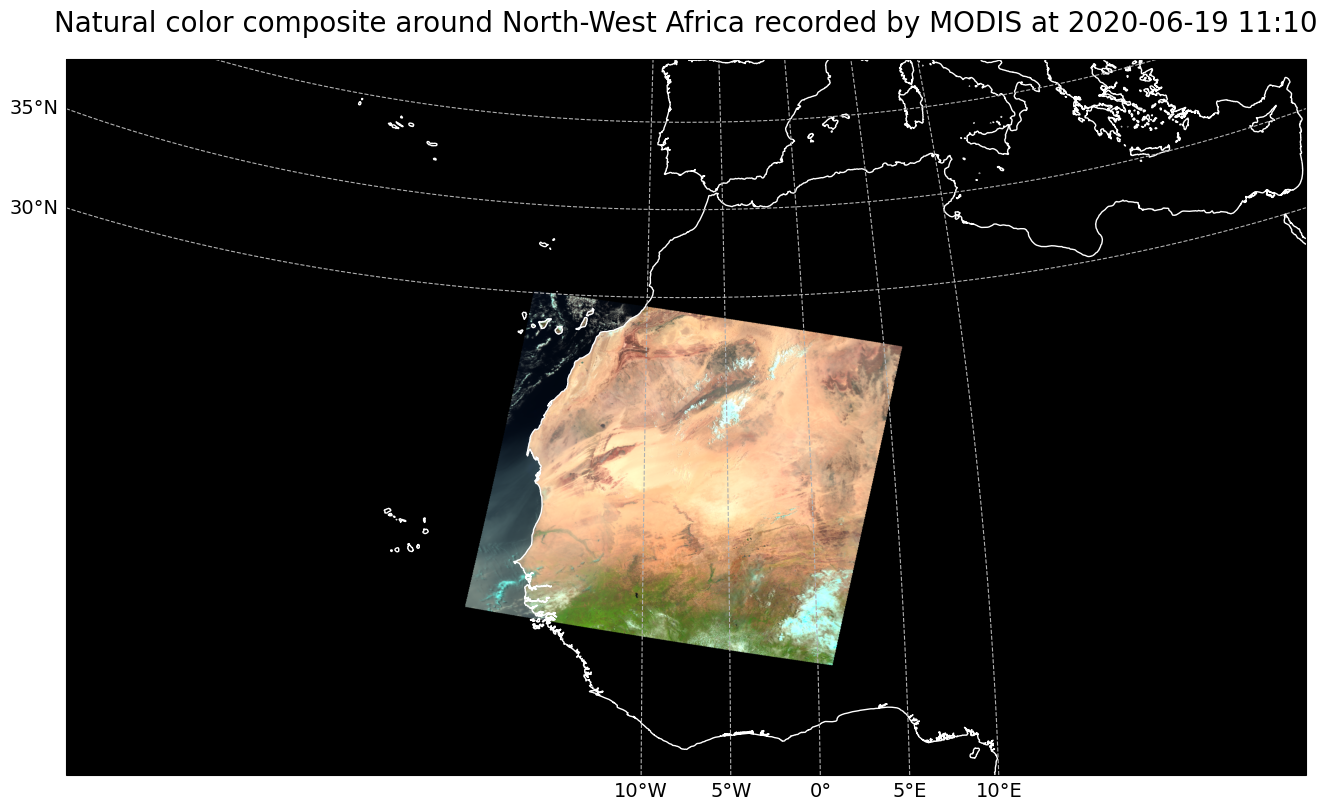

In [26]:
# ... and use it to generate an axes in our figure with the same CRS
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)

# Now we can add some coastlines...
ax.coastlines(resolution="10m", color="white")

# ... and a lat/lon grid:
gl = ax.gridlines(draw_labels=True, linestyle='--', xlocs=range(-10,11,5), ylocs=range(30,50,5))
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# In the end, we can plot our image data...
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")

# and add a title to our plot
plt.title("Natural color composite around North-West Africa recorded by MODIS at " + scn_resample_nc.start_time.strftime("%Y-%m-%d %H:%M"), fontsize=20, pad=20.0)


<br>

## <a id='vis_dust'></a> 5. Visualize and interpret the 'dust' RGB composite

In a final step, we would like to have a closer look at the [Dust RGB](https://user.eumetsat.int/resources/user-guides/dust-rgb-quick-guide) composite, whose primary aim is to support the detection of dust in the atmosphere.
The dust composite makes use of three window channels:
* **Red**: `IR12.0-IR10.8`
* **Green**: `IR10.8-IR.8.7`
* **Blue**: `IR10.8`

Since we already loaded the dust composite to our Scene object `scn_resample_nc`, we can visualize the dust composite with Satpy's built-in visualization function `show()`. The colours of the dust RGB can be interpreted as follows:
* `Magenta`: Dust or ash clouds
* `Black`: Cirrus clouds
* `Dark red`: Thick, high and cold ice clouds
* `Yellow`: Thick mid-level clouds
* `Darkblue`: Humid air in lower levels
* `Lilac`: Dry air in lower levels

Get more information about the Dust RGB in the [SEVIRI Dust RGB Quick Guide](https://user.eumetsat.int/resources/user-guides/dust-rgb-quick-guide).

The dust composite of 6 February at 10 UTC clearly show a dust cloud below the thicker cold ice cloud over northern Italy.

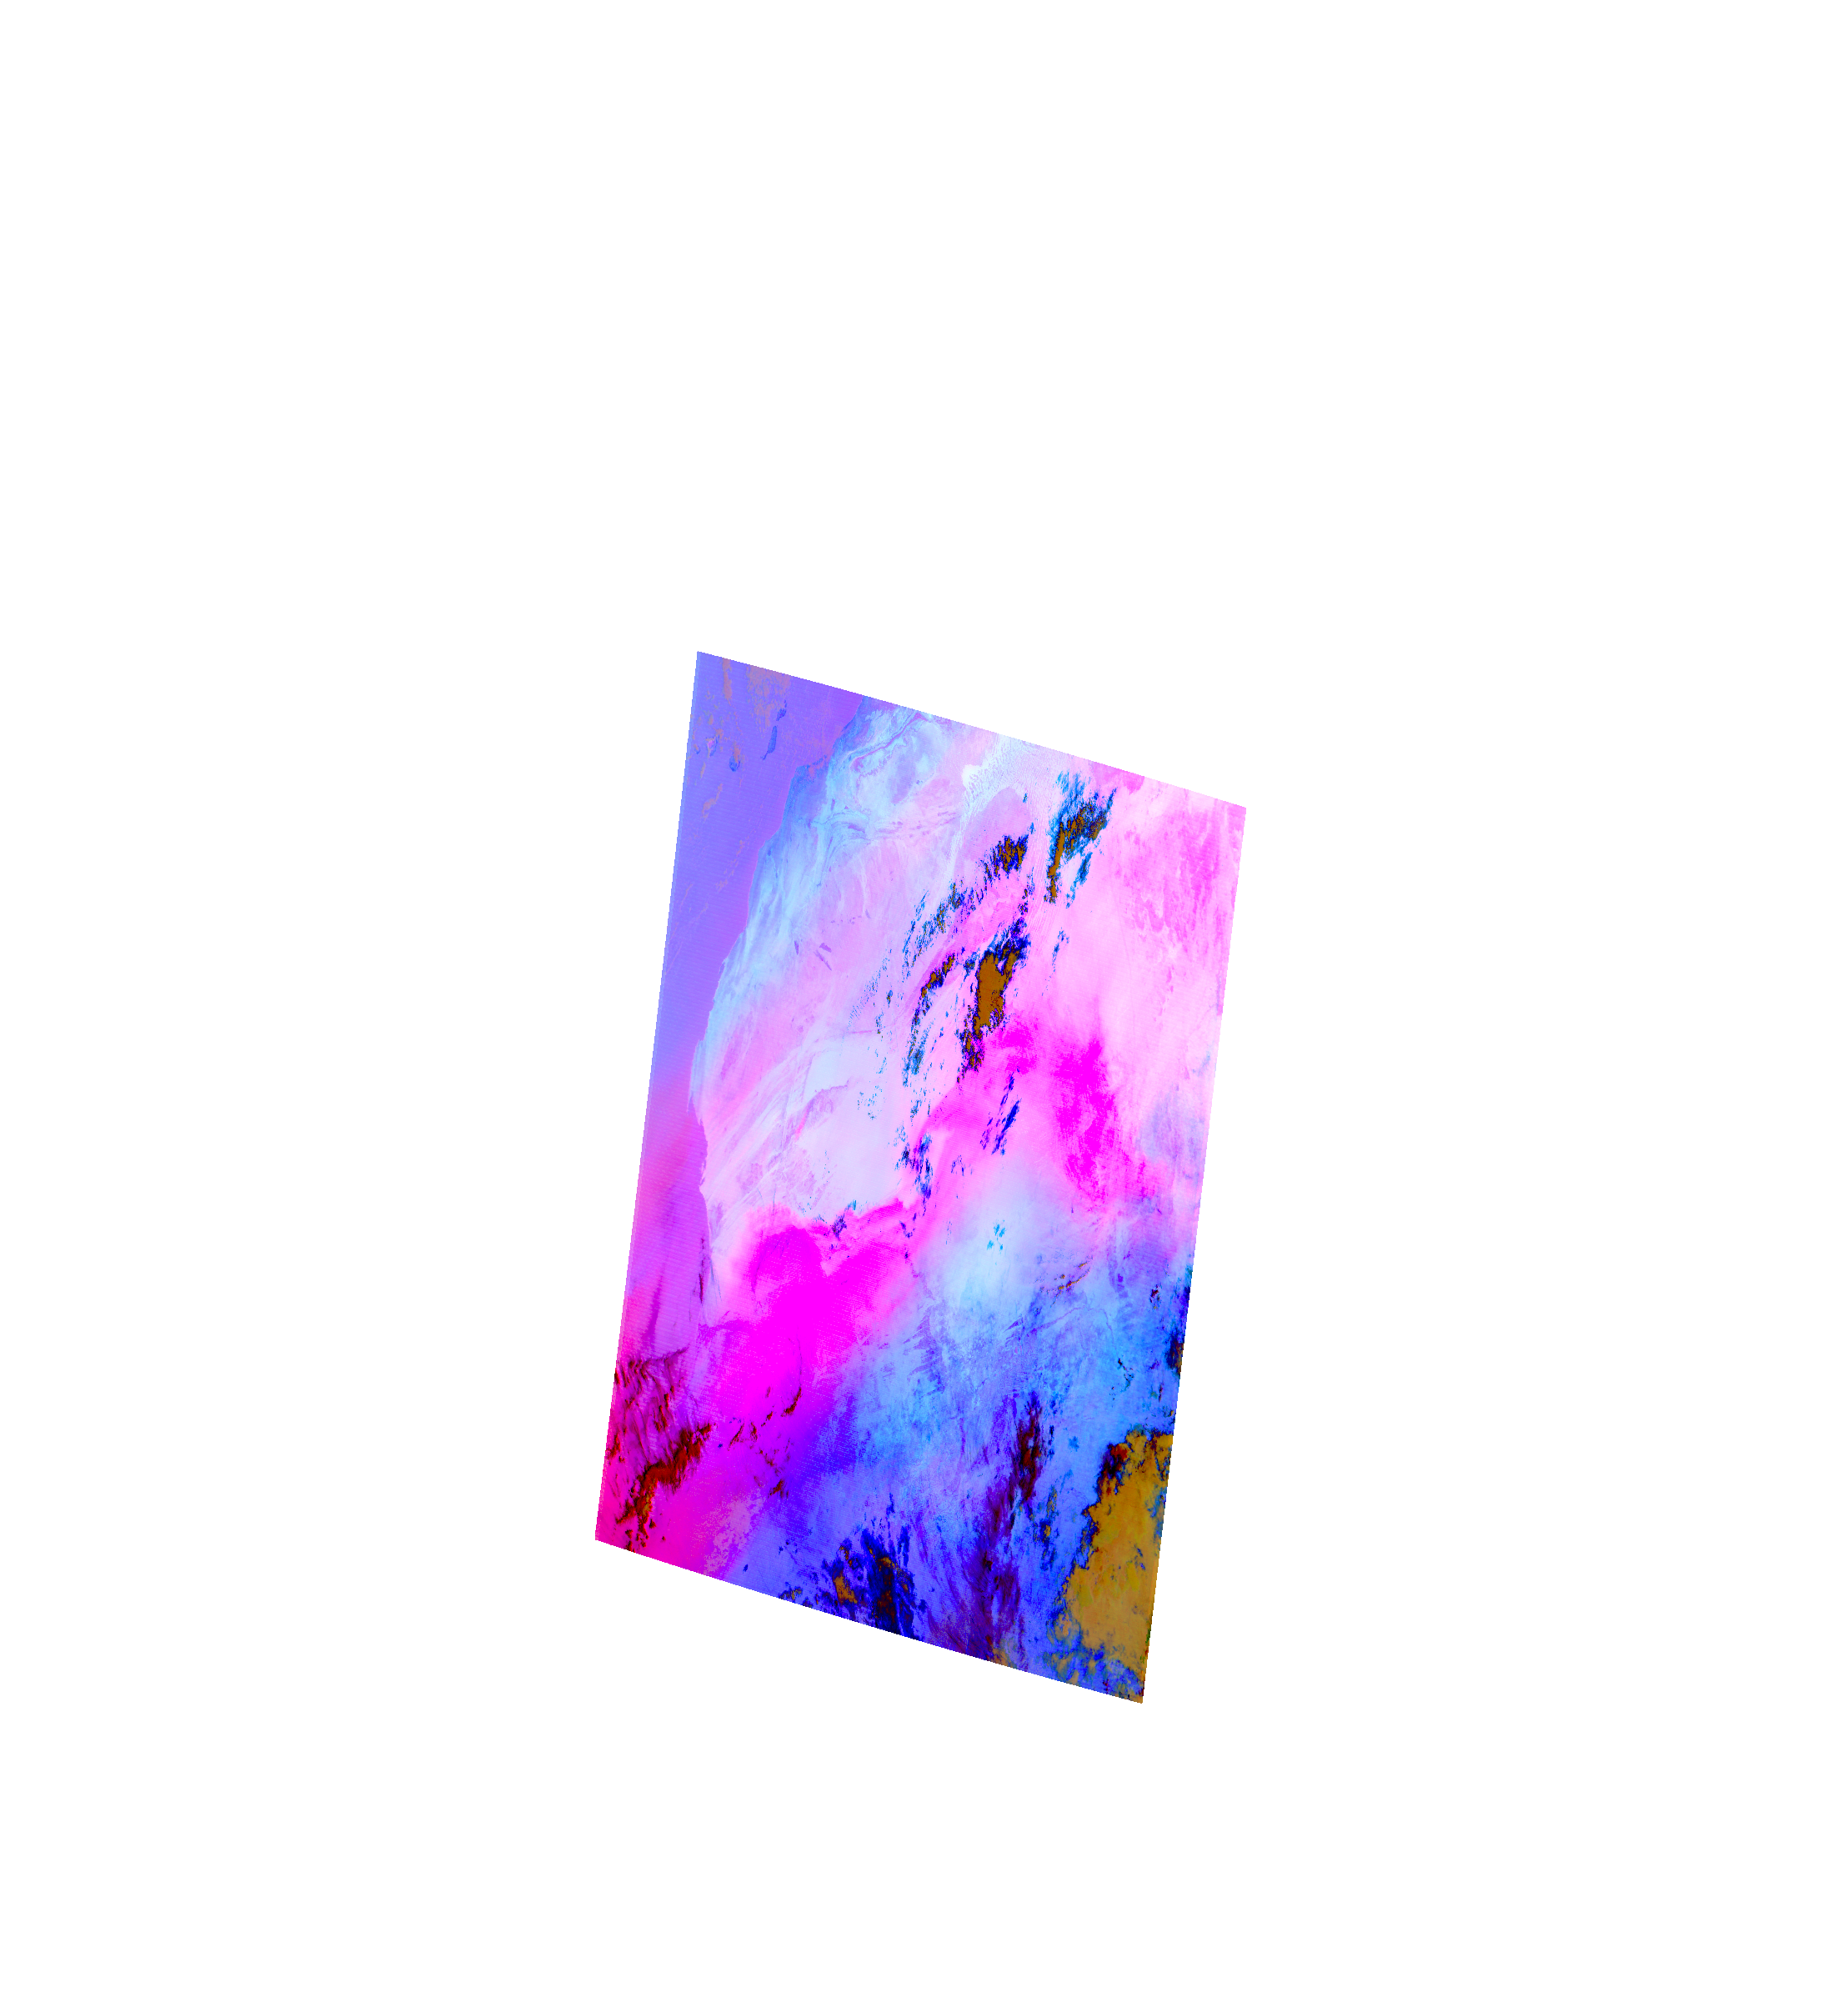

In [27]:
scn_resample_nc.show('dust')

<hr>

### References

* MODIS Characterization Support Team (MCST), 2017. MODIS 1km Calibrated Radiances Product. NASA MODIS Adaptive Processing System, Goddard Space Flight Center, USA: http://dx.doi.org/10.5067/MODIS/MOD021KM.061

* This notebook was adapted from: https://dustbook.ltpy.adamplatform.eu/docs/modis_rgb.html

* Some code in this notebook was adapted from the following sources:
  * origin: https://python-kurs.github.io/sommersemester_2019/units/S01E07.html
  * copyright: 2019, Marburg University
  * license: CC BY-SA 4.0
  * retrieved: 2024-05-03 Julia Wagemann



<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under <a href="../../LICENSE">GNU General Public License v3.0 only</a> and is developed under a Copernicus contract.

<p style="text-align:right;"> <a href='https://training.eumetsat.int'>EUMETSAT Training</a> | <a href='mailto:training@eumetsat.int'>Contact the training team</a></p>